## Homework 6

#### Imports and Load Dataset

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text, export_graphviz, plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.head().T

,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41.0,21.0,52.0,52.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0
population,322.0,2401.0,496.0,558.0,565.0
households,126.0,1138.0,177.0,219.0,259.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


#### Data Preparation

In [13]:
df_subset = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')].copy()

In [14]:
df_subset.ocean_proximity.unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

- Filling Missing Values

In [15]:
df_subset.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [16]:
df_subset = df_subset.fillna(0)
df_subset.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

- Log Transform of `median_house_value`

In [17]:
df_subset.median_house_value = np.log1p(df_subset.median_house_value)

701    12.973866
830    12.287657
859    12.419574
860    12.554971
861    12.287196
Name: median_house_value, dtype: float64

- Train Test Split

In [19]:
df_full_train, df_test = train_test_split(df_subset, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

- Prepare Feature and Target Matrices

In [22]:
dv = DictVectorizer(sparse=True)

In [24]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [27]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [28]:
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

#### Decision Tree Regressor

In [30]:
dt = DecisionTreeRegressor(max_depth=1)

In [31]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [33]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



- `ocean_proximity` has been used to make the decisions/splitting the data.

#### Random Forest Regressor

In [36]:
rf = RandomForestRegressor(n_estimators=10, 
                           random_state=1, 
                           n_jobs=-1)

In [38]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [39]:
y_pred = rf.predict(X_val)

In [41]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
round(rmse, 3)

0.245

- `RMSE` with `Random Forest Regressor` is `0.245`.

#### Random Forest Parameter Tuning

We will tune the model for `n_estimators` in the range of (10, 200] in step of 10.

In [42]:
estimators = np.arange(10, 201, 10)
print(estimators[:10])
print(estimators[-10:])

[ 10  20  30  40  50  60  70  80  90 100]
[110 120 130 140 150 160 170 180 190 200]


In [43]:
for n in estimators:
    rf = RandomForestRegressor(n_estimators=n, 
                            random_state=1, 
                            n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    print(f"estimators={n} --> RMSE={round(rmse, 3)}")

estimators=10 --> RMSE=0.245
estimators=20 --> RMSE=0.239
estimators=30 --> RMSE=0.237
estimators=40 --> RMSE=0.236
estimators=50 --> RMSE=0.235
estimators=60 --> RMSE=0.235
estimators=70 --> RMSE=0.234
estimators=80 --> RMSE=0.235
estimators=90 --> RMSE=0.235
estimators=100 --> RMSE=0.234
estimators=110 --> RMSE=0.234
estimators=120 --> RMSE=0.234
estimators=130 --> RMSE=0.234
estimators=140 --> RMSE=0.234
estimators=150 --> RMSE=0.234
estimators=160 --> RMSE=0.233
estimators=170 --> RMSE=0.233
estimators=180 --> RMSE=0.234
estimators=190 --> RMSE=0.234
estimators=200 --> RMSE=0.234


- At `n_estimators=50`, the `RMSE` of the model begins to stagnate.

Now, we shall tune the `max_depth` parameter.

In [44]:
max_depths = [10, 15, 20, 25]

In [46]:
for d in max_depths:
    errors = []
    for n in estimators:
        rf = RandomForestRegressor(n_estimators=n, 
                                max_depth=d,
                                random_state=1, 
                                n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        errors.append(rmse)

    print(f"max_depth={d}\t-->\tRMSE={round(np.mean(errors), 3)}")

max_depth=10	-->	RMSE=0.246
max_depth=15	-->	RMSE=0.236
max_depth=20	-->	RMSE=0.235
max_depth=25	-->	RMSE=0.235


`max_dpeth` of 20 and 25 have the same mean RMSE. Hence, we can choose the lower value. 20 

#### Feature Importance using Random Forest

In [47]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)

In [48]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [53]:
feature_importances = {}
for feature, score in zip(list(dv.get_feature_names_out()), list(rf.feature_importances_)):
    feature_importances[feature] = round(score, 4)

In [54]:
feature_importances

{'households': 0.0151,
 'housing_median_age': 0.0303,
 'latitude': 0.102,
 'longitude': 0.0862,
 'median_income': 0.3356,
 'ocean_proximity=<1H OCEAN': 0.2925,
 'ocean_proximity=INLAND': 0.0738,
 'population': 0.0271,
 'total_bedrooms': 0.0159,
 'total_rooms': 0.0214}

- The feature `median_income` has the highest value of feature importance, indicating that it is the most important feature. 

#### XGBoost

- Prepare `train` and `val` DMatrix

In [57]:
features = list(dv.get_feature_names_out())
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [58]:
features = [x.replace("=<", "_").replace(" ", "_").replace("=", "_") for x in features]

In [59]:
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity_1H_OCEAN',
 'ocean_proximity_INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [61]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [62]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [76]:
errors = {}

In [77]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        # print(line)
        it_line, train_line, val_line = line.split('\t')
        it = int(it_line.strip('[]'))
        train_auc = float(train_line.split(':')[1])
        val_auc = float(val_line.split(':')[1])

        results.append((it, train_auc, val_auc))

    out_df = pd.DataFrame(results, columns = ['iter_num', 'train_auc', 'val_auc'])

    return out_df

In [78]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [79]:
key = 'eta=%s' % (xgb_params['eta'])
errors[key] = parse_xgb_output(output)
key

'eta=0.3'

In [80]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [81]:
key = 'eta=%s' % (xgb_params['eta'])
errors[key] = parse_xgb_output(output)

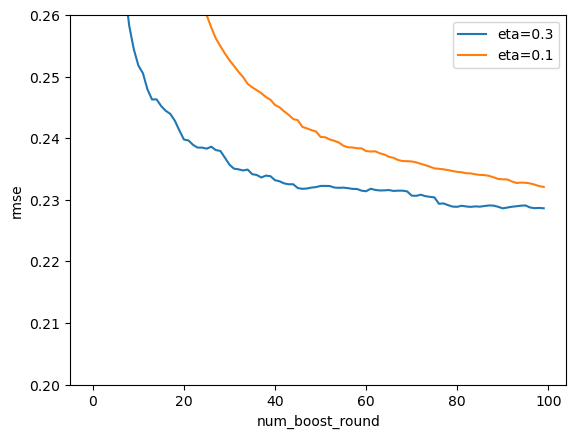

In [84]:
for eta, df_score in errors.items():
    plt.plot(df_score.iter_num, df_score.val_auc, label=eta)
plt.ylim(0.2, 0.26)
plt.xlabel("num_boost_round")
plt.ylabel("rmse")
plt.legend()
plt.show()

- As is evident from the plot above, `eta=0.3` yields a lower `rmse` an error metric in `100 boost rounds`.